In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import requests
import gzip
import re
from tqdm import trange

In [2]:
def load_data(url):
    data = requests.get(url).content
    data = gzip.decompress(data)
    data = np.frombuffer(data, dtype=np.uint8)
    return data

#load data and normalise images
train_images = load_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[16:].reshape((-1, 784)) / 255.0
train_labels = load_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
test_images = load_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[16:].reshape((-1, 784)) / 255.0
test_labels = load_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

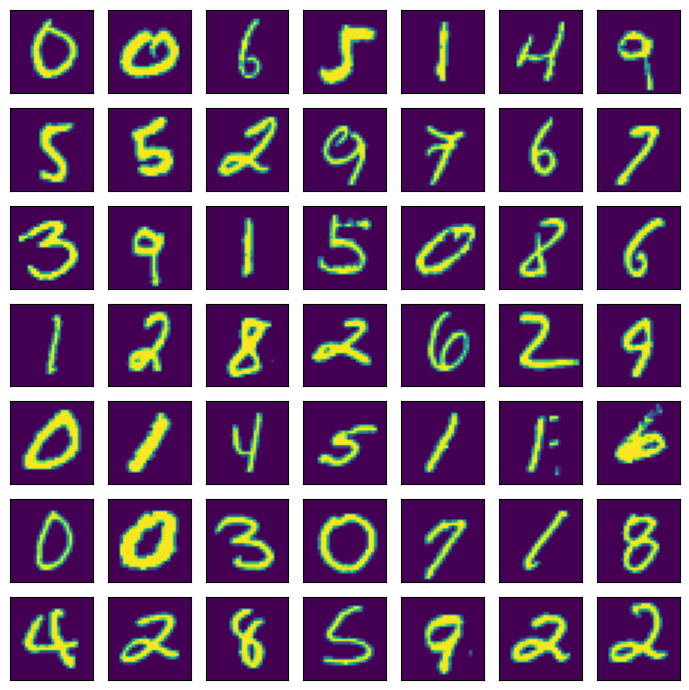

In [3]:
def sample(image_set: list, label_set: list, size: int):
    random = np.random.randint(0, image_set.shape[0], size=size)
    return image_set[random], label_set[random]

s = 7
X, _ = sample(image_set=train_images, label_set=train_labels, size=s*s)

fig, axs = plt.subplots(nrows=s, ncols=s, figsize=(s, s), subplot_kw={'xticks': [], 'yticks': []})
for ax, x in zip(axs.flat, X):
    ax.imshow(x.reshape(28, 28))
plt.tight_layout()
plt.show()

In [4]:
class Tensor:

    def __init__(self, data):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data).astype(np.float32)
        self.grad = None
        self._backward = lambda : None

    @property
    def shape(self):
        return self.data.shape

    @property
    def backward(self):
        return self._backward

    @property
    def grad(self):
        return self.grad

    def backward(self, grad=None):
        self.grad = 1
        self._backward.backward(grad)

    def __add__(self, other): 
        other = other if isinstance(other, Tensor) else Tensor(other)
        result = Tensor(self.data + other.data) 

        def _backward():
            self.grad += result.grad
            other.grad += result.grad

        result._backward = _backward
        return result

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        result = Tensor(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
        result._backward = _backward
        return result
        
    def __neg__(self): 
        return self * -1

    def __repr__(self):
        return f"Tensor(data={self.data}, grad={self.grad})"


In [5]:
class Layer:

    def __call__(self, *args):
        return self.forward(*args)

class Relu(Layer):

    def forward(self, x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)
      
    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

class Linear(Layer):

    def __init__(self, input, output, rate=1.):
        w = np.random.uniform(-1., 1., (input, output)) / np.sqrt(input * output)
        self.w = w.astype(np.float32)
        self.rate = rate
    
    def forward(self, x):
        self.x = x
        return np.dot(x,self.w)

    def backward(self, grad):
        w_grad = np.dot(self.x.T, grad)
        grad_input = np.dot(grad, self.w.T)
        self.w -= w_grad * self.rate
        return grad_input


class LogSoftMaxCrossEntropy(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss
      
    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad
    

In [6]:
class Net(Layer):

    def __init__(self, rate=0.01):
        self.rate =rate
        self.layers = [Linear(784,128, rate=rate), Relu(), Linear(128,10, rate=rate)]

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    def backward(self, grad):
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)
        return grad

    def evaluate(self): 
        result = self.forward(test_images)
        predictions = np.argmax(result, axis=1)
        accuracy = (predictions == test_labels).mean() 
        print("accuracy: %.2f" % accuracy)

    def train(self, epochs=1, batch_size=128):
        loss = LogSoftMaxCrossEntropy()
        for i in (t := trange(epochs)):
            X, y = sample(train_images, train_labels, batch_size)
            result = self.forward(X)
            loss(result, y)
            grad = loss.backward()
            self.backward(grad)
        
            predictions = np.argmax(result, axis=1)
            accuracy = (predictions == y).mean()
          
            t.set_description("accuracy: %.2f" % accuracy)
        

In [12]:
model = Net(rate=1.)
model.train(epochs=256)

accuracy: 0.95: 100%|██████████| 256/256 [00:04<00:00, 57.62it/s]


In [8]:
model.evaluate()

accuracy: 0.93
